In [32]:
import numpy as np

In [33]:
import matplotlib.pyplot as plt
%matplotlib nbagg

In [34]:
import os

## Utilities

In [35]:
def plot_rdsd(V, **kwarg):
	rfs = kwarg['real']
	sfs = kwarg['succ']
	N = rfs.shape[0]
	fig, axs = plt.subplots(2,1,sharex=True)
	xi = np.log10(V)
	lns = []
	for r in range(N):
		l = axs[0].plot(xi,((1-rfs[r]**2)*0.5)**0.5, label=r)
		lns.append(l[0])
		axs[1].plot(xi,((1-sfs[r]**2)*0.5)**0.5, label=r)
	axs[0].set_yscale('log')
	axs[0].set_ylabel('real distance')
	axs[1].set_yscale('log')
	axs[1].set_ylabel('successive distance')
	axs[1].set_xlabel('lg|V|')
	axs[0].plot([np.log10(80),np.ceil(np.log10(V.max())*2)/2.],[np.sqrt((1-0.995**2)/2)]*2,':',color='gray')
	plt.xlim(np.log10(80),np.ceil(np.log10(V.max())*2)/2.)

In [5]:
f2d = lambda f:(0.5*(1-f**2))**0.5

In [11]:
d2f = lambda d: (1-2*(d**2))**0.5

In [4]:
def saturation_statis(realfids, V, thres):
	saturateV = np.zeros((realfids.shape[0],),np.uint32)
	for r in range(realfids.shape[0]):
		saturation_point = np.argwhere(realfids[r] < thres).max()+1
		if saturation_point < realfids.shape[1]:
			saturateV[r] = V[saturation_point]
	return saturateV

def saturation_analyz(saturateV):
	msaturateV = np.ma.masked_array(saturateV, saturateV==0)
	nfail = sum(saturateV==0)
	if (saturateV==0).all():
		return -1, -1, nfail
	else:
		return msaturateV.mean(), msaturateV.std(), nfail

In [167]:
def linearRegress(x,y, intercept=False, yerr=None):
    ym = y.mean()
    xm = x.mean()
    N = x.size
    assert N == y.size
    xym = (x*y).mean()
    x2m = (x*x).mean()
    sig_x = x.std()
    slope = (xym-xm*ym)/(sig_x**2)
    rho = (xym-xm*ym) / (sig_x*y.std())
    sgm_slope = abs(slope*np.sqrt((rho**(-2)-1)/(N-2)))
    if yerr is not None:
        if isinstance(yerr,float):
            yerr = np.ones(N)*yerr
        sgm_slope_B = (((((x-xm)*yerr)**2).sum())**0.5) / (N*sig_x**2)
        sgm_slope = (sgm_slope**2+sgm_slope_B**2)**0.5
    if not intercept:
        return slope, sgm_slope, rho
    else:
        interc = ym-slope*xm
        sgm_interc = ((xm*sgm_slope)**2+((yerr**2).sum()/N)**2)**0.5
        return slope, sgm_slope, rho, interc, sgm_interc

In [291]:
def slope_stat(fids, Vmin, kys=['real','succ'], stat=True):
    V = fids['V']
    N = np.argwhere(V >= Vmin).min()
    print(N,end='\t')
    res = {}
    for ky in kys:
        rho_thres = 0.93 if ky=='real' else 0.87
        rfs = fids[ky]
        slps = []
        nfail = 0
        for rf in rfs:
            sl, ssl, rho = linearRegress(np.log10(V[N:]),0.5*np.log10(((1-rf[N:]**2)/2)))
            if abs(rho) > rho_thres:
                slps.append((sl,ssl))
            else:
                print("%.3f"%rho,end='\t')
                nfail +=1
        if len(slps)==0:
            raise ValueError("all negligible rho for %s"%ky)
        if stat:
            slps = np.array(slps,[('slope','f8'),('sigma_slope','f8')])
            res[ky] = (slps['slope'].mean(), (slps['slope'].std()**2+slps['sigma_slope'].mean()**2)**0.5,nfail)
        else:
            res[ky] = slps
    print("")
    return res

### Colors Utilities

<IPython.core.display.Javascript object>


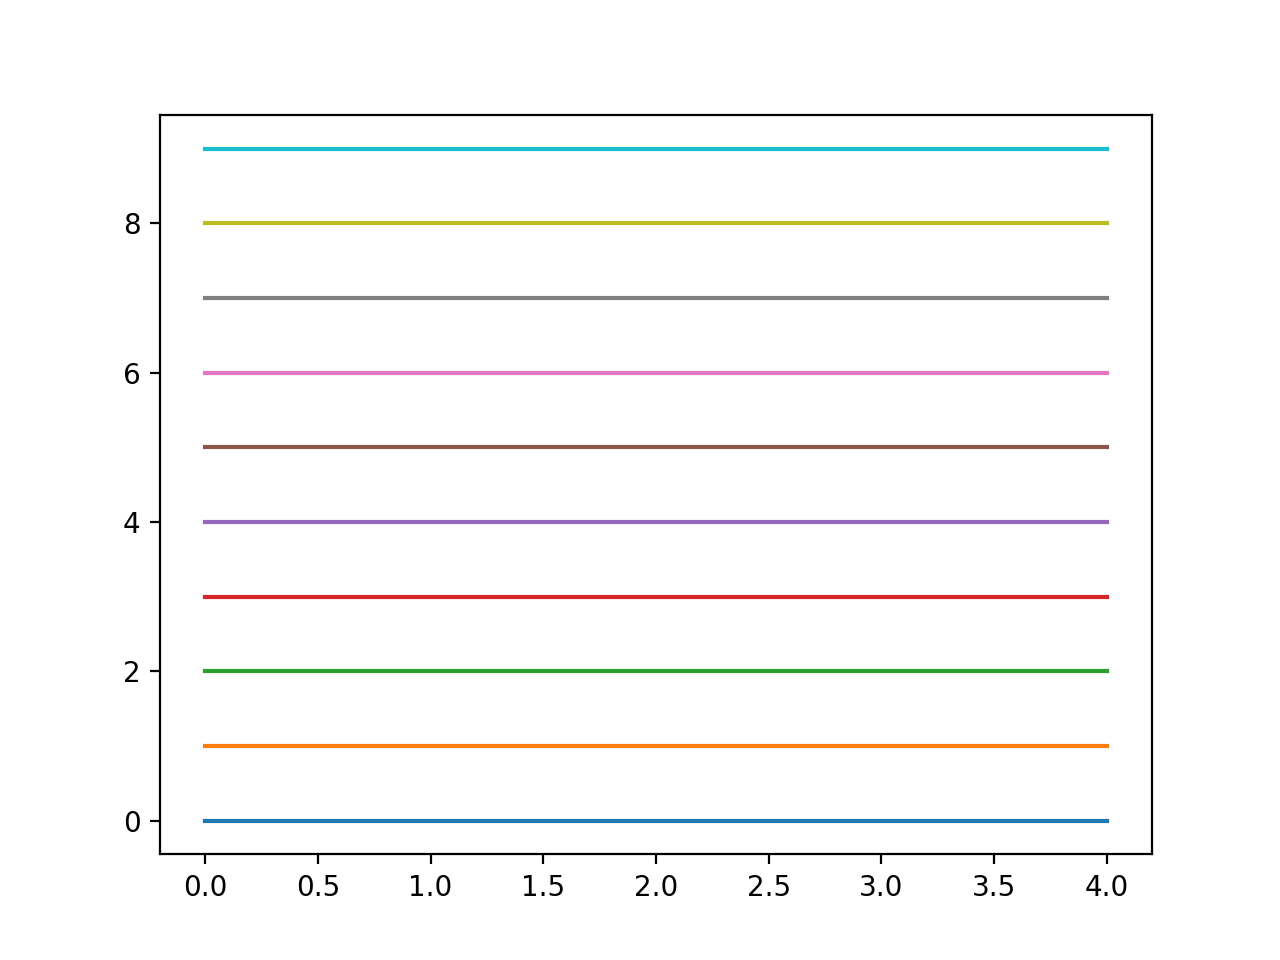

In [212]:
for r in range(10):
    plt.plot(range(5),[r]*5,color='C%d'%r)

In [496]:
gradPuBu = lambda n: plt.get_cmap('PuBu')(0.1+n/6*0.85)

## nbatch-N
### Global Fidelity 0.995

In [36]:
typs = ['W','dimer','cluster']
nlst1 = np.asarray([5,6,8,10,12,14,17,20,23,26,30,34,38,42])
nlst2 = np.asarray([6,8,10,12,14,16,18,20,22,26,30,34,38,42])
nlist_dict = {'W':nlst1,'cluster':nlst1,'dimer':nlst2}

In [37]:
def gather_dat(nlist):
    sat = [np.load('./%d/saturation.npz'%n) for n in nlist]
    assert np.asarray([w['nfail']==0 for w in sat]).all
    mean_std = np.empty((2,len(sat)),'d')
    margins = np.empty((2,len(sat)),'d')
    mean_std[0,:] = [x['mean'] for x in sat]
    mean_std[1,:] = [x['std'] for x in sat]
    margins[0,:] = mean_std[0,:]-mean_std[1,:]
    margins[1,:] = mean_std[0,:]+mean_std[1,:]
    return mean_std, margins

In [38]:
mean_std_global_dict = {}
marg_global_dict = {}

In [39]:
cd /Users/congzlwag/Git/Tomography/MLEreviv/

/Users/congzlwag/Git/Tomography/MLEreviv


In [40]:
for typ in typs:
    print(typ)
    os.chdir(typ)
    print(os.getcwd())
    mean_std_global_dict[typ], marg_global_dict[typ] = gather_dat(nlist_dict[typ])
    os.chdir('..')

W
/Users/congzlwag/Git/Tomography/MLEreviv/W
dimer
/Users/congzlwag/Git/Tomography/MLEreviv/dimer
cluster
/Users/congzlwag/Git/Tomography/MLEreviv/cluster


<IPython.core.display.Javascript object>


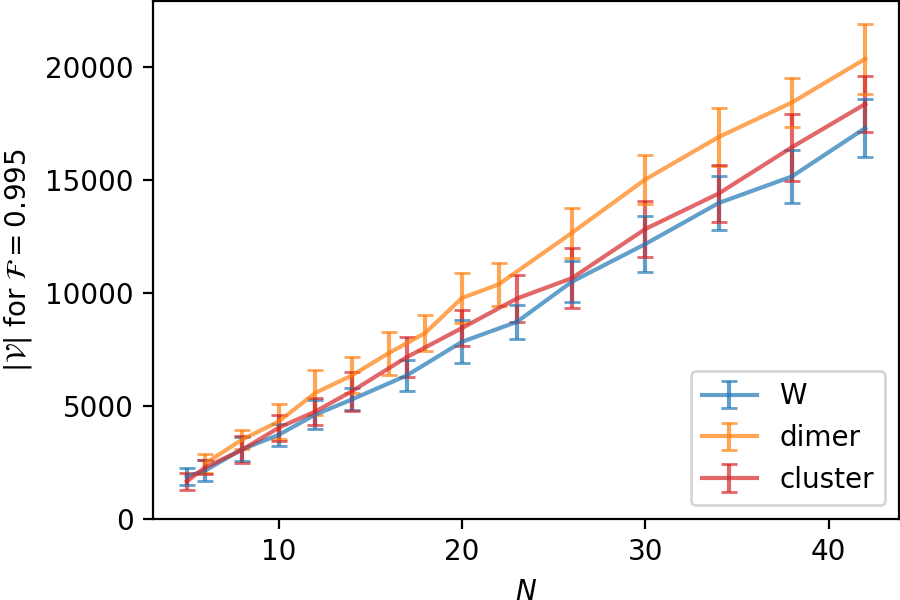

Text(0,0.5,'$|\\mathcal{V}|$ needed')

In [497]:
fig,ax=plt.subplots(figsize=(4.5,3))
colors = ["C0","C1","C3"]
for i,typ in enumerate(typs):
    mnstd = mean_std_global_dict[typ]
    ax.errorbar(nlist_dict[typ]-0*(i-1),mnstd[0],mnstd[1],alpha=0.7,capsize=3,label=typ,color=colors[i])
plt.ylim(ymin=0)
plt.legend(loc=4)
plt.xlabel(r"$N$")
plt.ylabel(r'$|\mathcal{V}|$ for $\mathcal{F}=0.995$')

In [498]:
plt.legend(loc=4)

In [499]:
plt.subplots_adjust(right=0.999,top=0.999,left=0.17,bottom=0.135)

In [23]:
plt.savefig("nBatch-size_globalfid_errorbar.pdf")

### per site Fidelity 0.9997

<IPython.core.display.Javascript object>


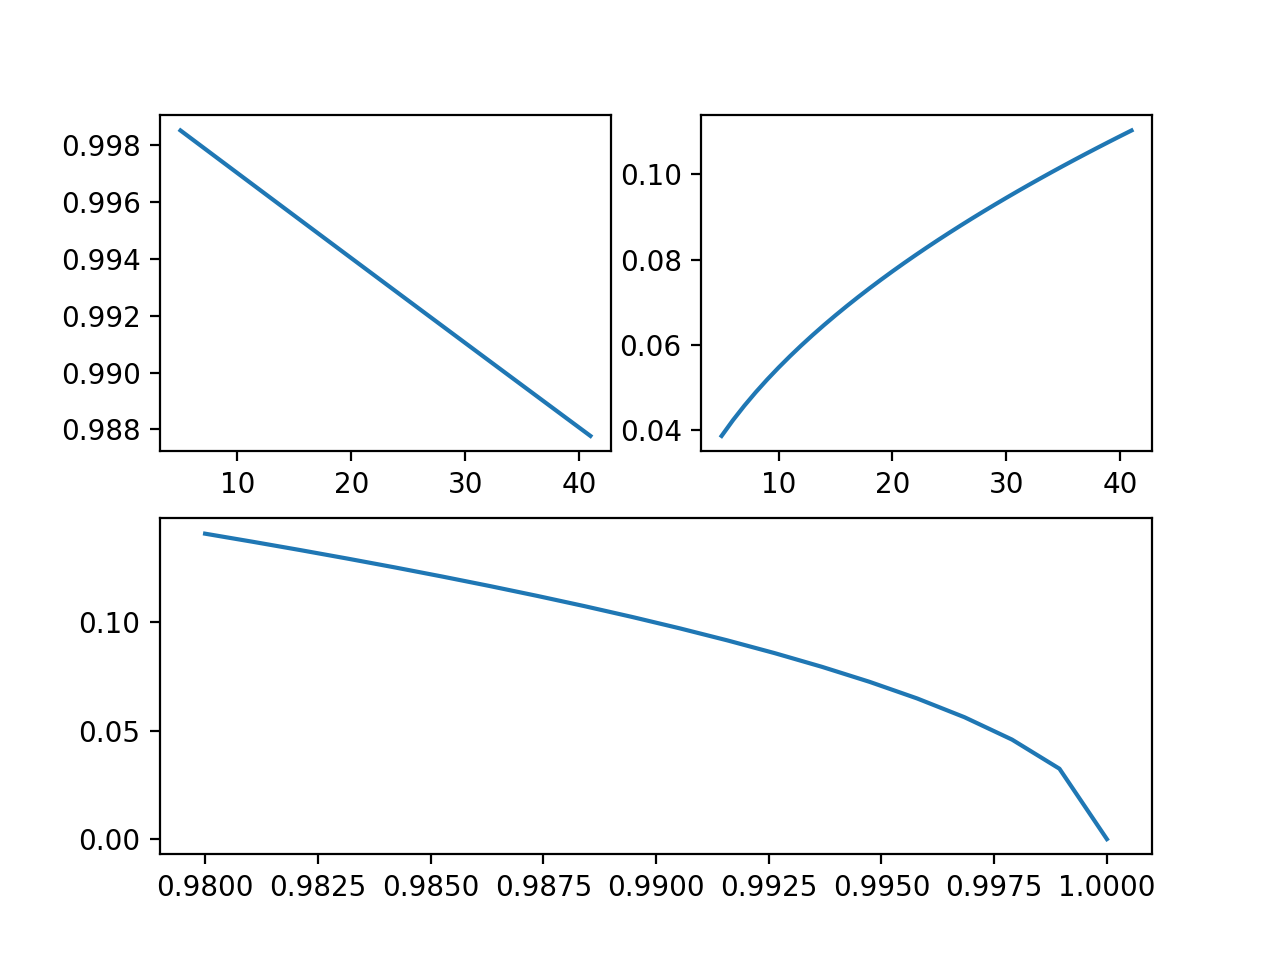

In [8]:
nlist = np.arange(5,42)
ax = plt.subplot(221)
ax.plot(nlist, 0.9997**nlist)
ax = plt.subplot(222)
ax.plot(nlist, f2d(0.9997**nlist))
ax = plt.subplot(212)
ax.plot(np.linspace(0.98,1,20),f2d(np.linspace(0.98,1,20)))

In [24]:
mean_std_dict = {}

for typ in typs:
    mean_std_dict[typ] = np.load(typ+'/sat_persite.npz')['mean_std']

<IPython.core.display.Javascript object>


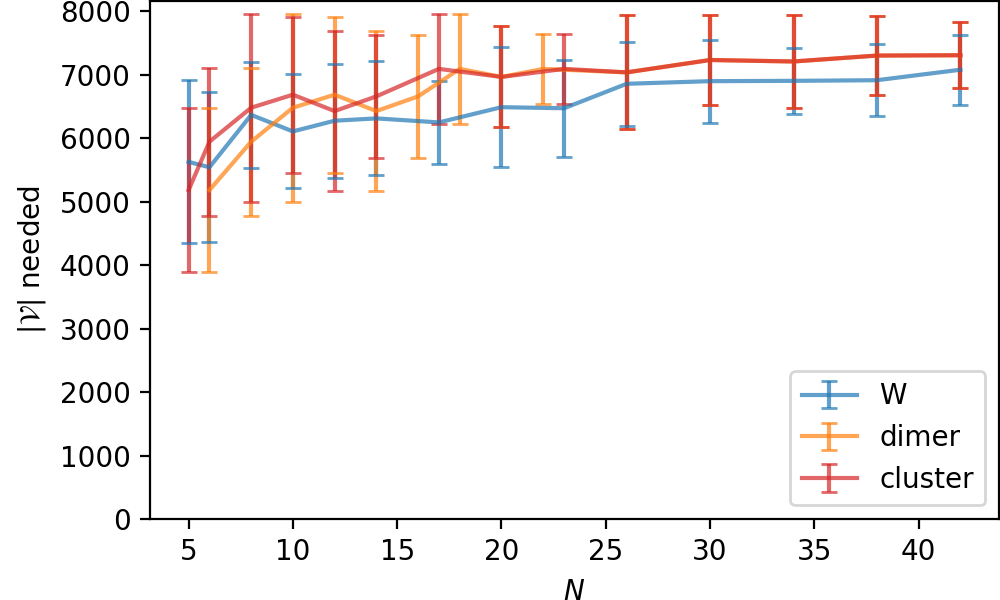

Text(0,0.5,'$|\\mathcal{V}|$ needed')

In [29]:
fig,ax=plt.subplots(figsize=(5,3))
for i,typ in enumerate(typs):
    ax.errorbar(nlist_dict[typ],mean_std_dict[typ][:,0],mean_std_dict[typ][:,1],alpha=0.7,capsize=3,label=typ,color=colors[i])

plt.ylim(ymin=0)
plt.legend(loc=4)
plt.xlabel(r'$N$')
plt.ylabel(r'$|\mathcal{V}|$ needed')

In [66]:
plt.ylim(ymin=0)
plt.legend(loc=4)
plt.xlabel(r'$N$')
plt.ylabel(r'$|\mathcal{V}|$ needed')

Text(0,0.5,'$|\\mathcal{V}|$ needed')

In [30]:
plt.subplots_adjust(right=0.999,top=0.999,left=0.15,bottom=0.135)

In [31]:
plt.savefig("nBatch-size_fidpersite_errorbar.pdf")

In [22]:
plt.subplots_adjust(right=0.999,top=0.999,left=0.15,bottom=0.135)

In [23]:
plt.savefig("nBatch-size_globalfid_errorbar.pdf")

<IPython.core.display.Javascript object>


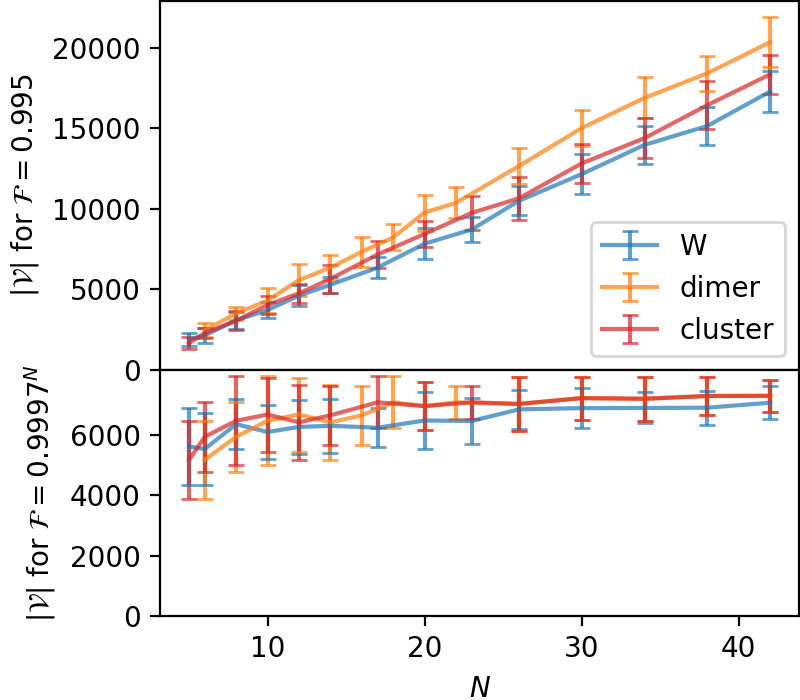

Text(0.5,0,'$N$')

In [551]:
fig,axs=plt.subplots(2,1,sharex=True,gridspec_kw={'height_ratios':[3,2]},figsize=(4,3.5))
colors = ["C0","C1","C3"]
ax = axs[0]
for i,typ in enumerate(typs):
    mnstd = mean_std_global_dict[typ]
    ax.errorbar(nlist_dict[typ],mnstd[0],mnstd[1],alpha=0.7,capsize=3,label=typ,color=colors[i])
ax.set_ylim(ymin=0)
ax.set_ylabel(r'$|\mathcal{V}|$ for $\mathcal{F}=0.995$')
ax.legend(loc=4)

ax = axs[1]
for i,typ in enumerate(typs):
    ax.errorbar(nlist_dict[typ],mean_std_dict[typ][:,0],mean_std_dict[typ][:,1],alpha=0.7,capsize=3,label=typ,color=colors[i])
ax.set_ylim(ymin=0)
ax.set_ylabel(r'$|\mathcal{V}|$ for $\mathcal{F}=0.9997^N$')
ax.set_xlabel(r"$N$")

In [552]:
plt.subplots_adjust(right=0.999,top=0.999,left=0.2,hspace=0.0,bottom=0.12)

In [553]:
axs[1].set_yticks(np.arange(0,8000,2000))

In [554]:
plt.savefig('V-N_united_sealed.pdf')

### Rand inited states

In [112]:
cd /Users/congzlwag/Git/Tomography/MLEreviv/trial14-RandTarget/

/Users/congzlwag/Git/Tomography/MLEreviv/trial14-RandTarget


In [65]:
rand_sat ={}

In [160]:
for d in [1,2]:
    os.chdir(str(d))
    mn_std, _ = gather_dat(nlst1)
    rand_sat[d] = mn_std
    os.chdir('..')

In [158]:
for d in [3]:
    os.chdir(str(d))
    mn_std, _ = gather_dat(nlst1[:-1])
    rand_sat[d] = mn_std
    os.chdir('..')

In [265]:
pwd

'/Users/congzlwag/Git/Tomography/MLEreviv/trial14-RandTarget'

In [266]:
n14 = []
for d in range(1,7):
    sat = np.load('%d/14/saturation.npz'%d)
    print(sat['nfail'])
    n14.append((sat['mean'],sat['std']))

0
0
0
0
0
0


In [267]:
n14 = np.array(n14,dtype=[('mean','f8'),('std','f8')])

In [268]:
n14

array([( 1465.        ,  361.25937127), ( 5533.33333333,  899.50603728),
       (13870.        , 1543.85880183), (27425.        , 2249.55736387),
       (42619.44444444, 2451.21278876), (61123.88888889, 3069.2971307 )],
      dtype=[('mean', '<f8'), ('std', '<f8')])

In [269]:
linearRegress(np.log(np.arange(1,7)),np.log(n14['mean']),True,n14['std']/n14['mean'])

(2.113435960391699,
 0.13464860581704627,
 0.9993206912403481,
 7.240124636844908,
 0.14882694476302222)

<IPython.core.display.Javascript object>


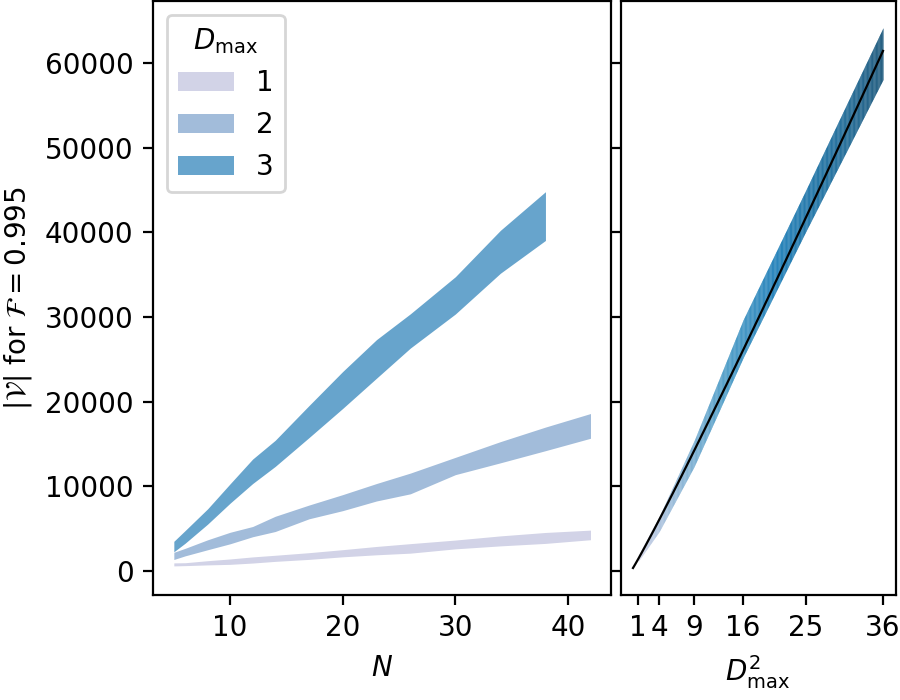

Text(0,0.5,'$|\\mathcal{V}|$ for $\\mathcal{F}=0.995$')

In [502]:
fig, axs = plt.subplots(1,2,figsize=(4.5,3.5),gridspec_kw={'width_ratios':[5,3]},sharey=True)
ax = axs[0]
c = 'darkcyan'
for n in [1,2,3]:
    randa = rand_sat[n]
    nlst = nlst1[:randa.shape[1]]
    ax.fill_between(nlst, (randa[0]-randa[1]), (randa[0]+randa[1]),lw=0,label=n,color=gradPuBu(n))
ax.legend(loc=2,title=r'$D_\mathrm{max}$')

ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$|\mathcal{V}|$ for $\mathcal{F}=0.995$')

In [504]:
plt.subplots_adjust(right=0.995,top=0.999,bottom=0.15,left=0.17,wspace=0.025)

In [400]:
from scipy.interpolate import interp1d

In [505]:
xi = np.arange(1,7)**2
yu = interp1d(xi,n14['mean']+n14['std'])
yd = interp1d(xi,n14['mean']-n14['std'])
xi = np.linspace(xi[0],xi[-1],300)
yu = yu(xi)
yd = yd(xi)

In [503]:
xi = np.arange(1,7)**2
xi = np.linspace(xi[0],xi[-1],300)
ax = axs[1]
for mm in range(xi.size-1):
    ax.fill_between(xi[mm:mm+2],yd[mm:mm+2],yu[mm:mm+2],lw=0,color=gradPuBu(xi[mm]**0.5))
ax.set_xticks(np.arange(1,7)**2)
ax.set_xlabel(r"$D_\mathrm{max}^2$")

Text(0.5,18.4444,'$D_\\mathrm{max}^2$')

In [506]:
xi = np.linspace(0.5,6,100)
plt.plot(xi**2, np.exp(2.113*np.log(xi)+7.240), ls='-',color='k',lw=0.8)

In [481]:
ax = axs[0]
ax.plot([14,14],[0,30000],color='k',ls='--',lw=0.8)

In [472]:
plt.savefig('randinit.pdf')

## Manual analyze saturation of the Error Robustness experiments

In [482]:
typs = ['W10','W20','dimer10','dimer20','cluster10','cluster20']
elist= np.array([0,0.005,0.01,0.02,0.05,0.08,0.1,0.14])

In [483]:
err_mean_std_dict = {}

In [484]:
cd /Users/congzlwag/Git/Tomography/MLEreviv/errRobust

/Users/congzlwag/Git/Tomography/MLEreviv/errRobust


In [8]:
for typ in typs:
    print(typ)
    err_mean_std_dict[typ] = []
    os.chdir(typ)
    for i,e in enumerate(elist):
        if typ=='W20' and i== elist.size-1:
            continue
        os.chdir("%g"%e)
        fids = np.load('fids.npz')
        mn,sd,nf = saturation_analyz(saturation_statis(fids['real'],fids['V'],0.995))
        err_mean_std_dict[typ].append((mn,sd))
        print(e,nf)
        os.chdir('..')
    err_mean_std_dict[typ] = np.array(err_mean_std_dict[typ], dtype=[('mean','f8'),('std','f8')])
    os.chdir('..')

W10
0.0 0
0.005 0
0.01 0
0.02 0
0.05 0
0.08 0
0.1 1
0.14 2
W20
0.0 0
0.005 0
0.01 0
0.02 0
0.05 0
0.08 0
0.1 1
dimer10
0.0 0
0.005 0
0.01 0
0.02 0
0.05 0
0.08 0
0.1 0
0.14 0
dimer20
0.0 0
0.005 0
0.01 0
0.02 0
0.05 0
0.08 0
0.1 0
0.14 0
cluster10
0.0 0
0.005 0
0.01 0
0.02 0
0.05 0
0.08 0
0.1 0
0.14 0
cluster20
0.0 0
0.005 0
0.01 0
0.02 0
0.05 0
0.08 0
0.1 0
0.14 0


In [9]:
(err_mean_std_dict['W20']).size

7

<IPython.core.display.Javascript object>


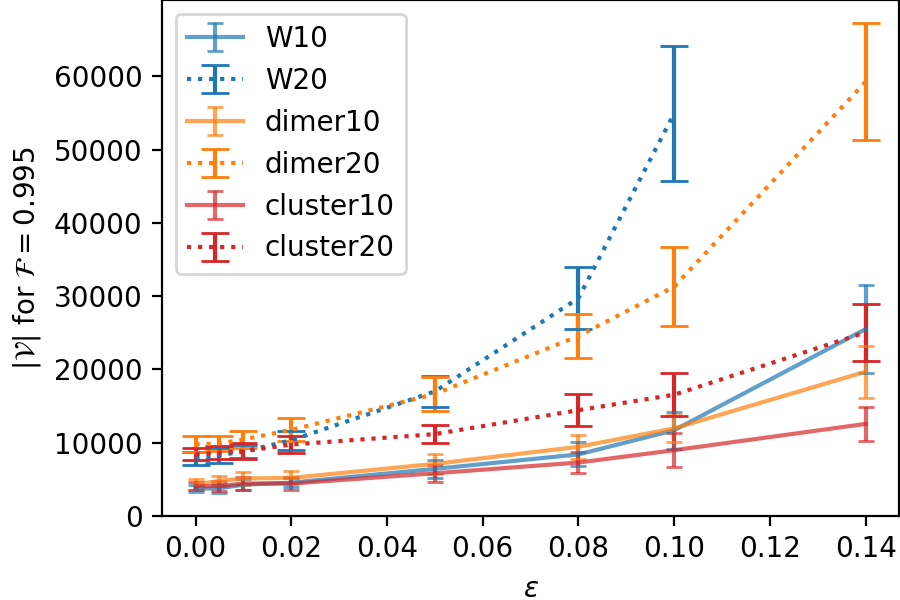

Text(0,0.5,'$|\\mathcal{V}|$ for $\\mathcal{F}=0.995$')

In [25]:
colors = [0,0,1,1,3,3,4]
fig,ax = plt.subplots(figsize=(4.5,3))
for i,typ in enumerate(typs):
    mn_std = err_mean_std_dict[typ]
    if typ[-2:]=='20':
        plt.errorbar(elist[:mn_std.size],mn_std['mean'],mn_std['std'],capsize=5,label=typ,color="C%d"%colors[i],ls=':')
    else:
        plt.errorbar(elist[:mn_std.size],mn_std['mean'],mn_std['std'],alpha=0.7,capsize=3,label=typ,color="C%d"%colors[i])
plt.legend()
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$|\mathcal{V}|$ for $\mathcal{F}=0.995$')

In [26]:
plt.yticks(np.arange(0,70000,10000))

([<matplotlib.axis.YTick at 0xa21bb3c88>,
 <a list of 7 Text yticklabel objects>)

In [27]:
plt.subplots_adjust(left=0.18,right=0.999,top=1.0,bottom=0.14)

In [28]:
plt.savefig("nBatch-nologerr.pdf")

## Statistics about the Asymptotic Behavior

In [485]:
typs = ['W','dimer','cluster']
nlst1 = np.asarray([5,6,8,10,12,14,17,20,23,26,30,34,38,42])
nlst2 = np.asarray([6,8,10,12,14,16,18,20,22,26,30,34,38,42])
nlist_dict = {'W':nlst1,'cluster':nlst1,'dimer':nlst2}

In [486]:
cd /Users/congzlwag/Git/Tomography/MLEreviv/

/Users/congzlwag/Git/Tomography/MLEreviv


In [487]:
kys = ['real','succ']
mighty_dict = {}
for k in kys:
    mighty_dict[k] = {}
for typ in typs:
    os.chdir(typ)
    for k in kys:
        mighty_dict[k][typ] = []
    for n in nlist_dict[typ]:
        os.chdir(str(n))
        fids=np.load('fids.npz')
        if n < 10:
            Vmin = 10**3.5
        else:
            Vmin = 10**3.6
        res = slope_stat(fids,Vmin)
        for k in kys:
            mighty_dict[k][typ].append(res[k])
        os.chdir("..")
    for k in kys:
        mighty_dict[k][typ] = np.array(mighty_dict[k][typ],dtype=[("slope","f8"),('sigma_slope',"f8"),('nfail','i4')])
    os.chdir('..')

77	-0.928	-0.929	-0.883	-0.889	
77	-0.799	-0.923	
77	-0.926	
97	-0.913	
97	-0.878	
97	
97	
97	
97	
97	
97	
97	
97	-0.805	-0.828	
97	
77	-0.854	-0.894	
77	
97	
97	
97	
97	
97	
97	
97	
97	
97	
97	
97	
97	
77	-0.907	-0.895	-0.844	-0.927	-0.915	-0.811	
77	-0.929	-0.906	
77	
97	-0.901	-0.922	-0.910	-0.928	-0.883	
97	
97	-0.930	
97	
97	
97	
97	
97	
97	
97	
97	


<IPython.core.display.Javascript object>


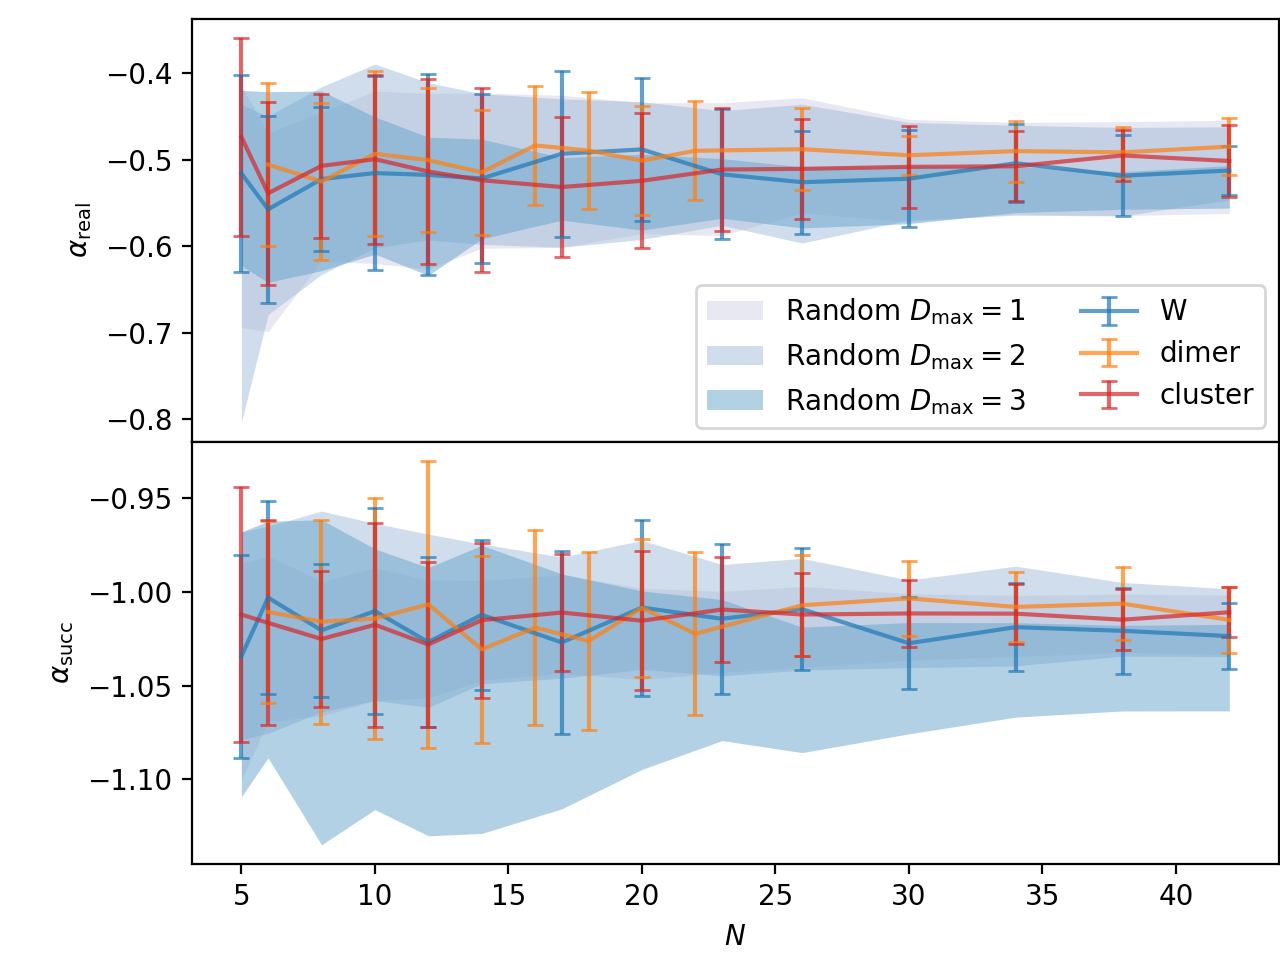

Text(0,0.5,'$\\alpha_\\mathrm{succ}$')

In [529]:
colors = ["C0","C1","C3"]
fig,axes = plt.subplots(2,1,sharex=True)
ax = axes[0]
for i,typ in enumerate(typs):
    ax.errorbar(nlist_dict[typ],mighty_dict['real'][typ]['slope'],mighty_dict['real'][typ]['sigma_slope'],label=typ,capsize=3,alpha=0.7,color=(colors[i]))
ax.set_ylabel(r"$\alpha_\mathrm{real}$")
ax = axes[1]
for i,typ in enumerate(typs):
    ax.errorbar(nlist_dict[typ],mighty_dict['succ'][typ]['slope'],mighty_dict['succ'][typ]['sigma_slope'],label=typ,capsize=3,alpha=0.7,color=(colors[i]))
ax.set_xlabel(r'$N$')
ax.set_ylabel(r"$\alpha_\mathrm{succ}$")

In [530]:
for j,k in enumerate(kys):
    ax = axes[j]
    for i,d in enumerate(range(1,4)):
        slops = rand_init_slopes[k][i]
        eb = ax.fill_between(nlst1,slops['slope']+slops['sigma_slope'],slops['slope']-slops['sigma_slope'],lw=0,label=r"Random $D_\mathrm{max}=%d$"%d,color=gradPuBu(d),alpha=0.5)

In [531]:
plt.subplots_adjust(right=0.999,top=0.98,left=0.15,hspace=0.0,bottom=0.1)
axes[0].legend(loc=4,ncol=2)

In [532]:
plt.savefig("alphas-N.pdf")

## Random Inited targets

In [218]:
cd /Users/congzlwag/Git/Tomography/MLEreviv/

/Users/congzlwag/Git/Tomography/MLEreviv


In [489]:
dir_without = "trial14-RandTarget/"

In [490]:
rand_init_slopes = {}
kys = ['real','succ']

In [524]:
for k in kys:
    rand_init_slopes[k] = []
for i,d in enumerate(range(1,4)):
    if d==1:
        Vmin = 10**3.0
    else:
        Vmin = 10**3.8
    for k in kys:
        rand_init_slopes[k].append([])
    for n in nlst1:
        print(n,end='\t')
        fids = np.load(dir_without+"/%d/%d/fids.npz"%(d,n))
        res = (slope_stat(fids,Vmin))
        for k in kys:
            rand_init_slopes[k][i].append(res[k])
    for k in kys:
        rand_init_slopes[k][i] = np.array(rand_init_slopes[k][i],[('slope','f8'),('sigma_slope','f8'),('nfail','i4')])

5	22	-0.853	-0.801	-0.920	-0.890	-0.849	-0.908	-0.926	-0.858	-0.863	-0.911	-0.803	-0.878	-0.588	-0.730	-0.904	-0.918	-0.924	-0.928	-0.864	-0.911	-0.770	-0.781	
6	22	-0.886	-0.912	-0.588	-0.922	-0.647	-0.910	-0.808	-0.924	-0.892	-0.911	-0.903	-0.888	-0.687	-0.925	-0.902	-0.864	-0.870	-0.930	-0.743	
8	22	-0.751	-0.795	-0.888	-0.832	-0.892	-0.905	-0.885	
10	22	-0.909	-0.835	-0.901	-0.908	-0.895	-0.914	-0.918	-0.910	-0.802	-0.927	-0.880	-0.923	
12	22	-0.918	-0.911	-0.844	-0.925	-0.916	-0.927	
14	22	-0.921	-0.843	-0.926	-0.815	
17	22	
20	22	-0.930	
23	22	
26	22	
30	22	
34	22	
38	22	
42	22	
5	155	-0.872	-0.883	-0.917	-0.903	-0.823	-0.866	-0.918	-0.907	-0.770	-0.882	-0.921	-0.819	-0.797	-0.915	-0.613	-0.835	-0.860	-0.727	-0.898	-0.778	-0.927	-0.901	-0.907	-0.857	-0.825	-0.813	-0.861	-0.865	-0.797	-0.836	-0.859	-0.823	-0.847	-0.837	-0.864	-0.808	-0.870	-0.861	-0.834	-0.866	-0.862	-0.831	-0.857	-0.846	-0.860	-0.809	-0.858	-0.844	-0.868	-0.867	-0.847	-0.868	-0.839	-0.860	-0.848	
6	155	-0.857	-0.

In [286]:
cd /Users/congzlwag/Git/Tomography/MLEreviv/

/Users/congzlwag/Git/Tomography/MLEreviv


In [288]:
nlist_Rand = {}

In [289]:
nlist_Rand[1] = nlst1
nlist_Rand[2] = nlst1
nlist_Rand[3] = nlst1[:-1]
for d in range(4,7):
    nlist_Rand[d] = [14]

In [294]:
kys = ['real','succ']

In [537]:
grand_slope_stat_pool = {"real":[],"succ":[]}

for typ in typs:
    print(typ)
    for n in nlist_dict[typ]:
        print(n,end='\t\t')
        fids = np.load('%s/%d/fids.npz'%(typ,n))
        if n < 10:
            Vmin = 10**3.5
        else:
            Vmin = 10**3.6
        slops = slope_stat(fids,Vmin,stat=False)
        for k in kys:
            grand_slope_stat_pool[k] = grand_slope_stat_pool[k]+slops[k]
for d in range(1,7):
    print("random Dmax =",d)
    if d==1:
        Vmin = 10**3.0
    else:
        Vmin = 10**3.6
    for n in nlist_Rand[d]:
        print(n,end='\t\t')
        fids = np.load('trial14-RandTarget/%d/%d/fids.npz'%(d,n))
        slops = slope_stat(fids,Vmin,stat=False)
        for k in kys:
            grand_slope_stat_pool[k] = grand_slope_stat_pool[k]+slops[k]

W
5		77	-0.928	-0.929	-0.883	-0.889	
6		77	-0.799	-0.923	
8		77	-0.926	
10		97	-0.913	
12		97	-0.878	
14		97	
17		97	
20		97	
23		97	
26		97	
30		97	
34		97	
38		97	-0.805	-0.828	
42		97	
dimer
6		77	-0.854	-0.894	
8		77	
10		97	
12		97	
14		97	
16		97	
18		97	
20		97	
22		97	
26		97	
30		97	
34		97	
38		97	
42		97	
cluster
5		77	-0.907	-0.895	-0.844	-0.927	-0.915	-0.811	
6		77	-0.929	-0.906	
8		77	
10		97	-0.901	-0.922	-0.910	-0.928	-0.883	
12		97	
14		97	-0.930	
17		97	
20		97	
23		97	
26		97	
30		97	
34		97	
38		97	
42		97	
random Dmax = 1
5		22	-0.853	-0.801	-0.920	-0.890	-0.849	-0.908	-0.926	-0.858	-0.863	-0.911	-0.803	-0.878	-0.588	-0.730	-0.904	-0.918	-0.924	-0.928	-0.864	-0.911	-0.770	-0.781	
6		22	-0.886	-0.912	-0.588	-0.922	-0.647	-0.910	-0.808	-0.924	-0.892	-0.911	-0.903	-0.888	-0.687	-0.925	-0.902	-0.864	-0.870	-0.930	-0.743	
8		22	-0.751	-0.795	-0.888	-0.832	-0.892	-0.905	-0.885	
10		22	-0.909	-0.835	-0.901	-0.908	-0.895	-0.914	-0.918	-0.910	-0.802	-0.927	-0.880	-0.923	
12

In [538]:
for k in kys:
    grand_slope_stat_pool[k] = np.array(grand_slope_stat_pool[k],dtype=[('slope','f8'),('sigma_slope','f8')])

In [539]:
for k in kys:
    slops = grand_slope_stat_pool[k]
    print(k,slops['slope'].mean(),(slops['slope'].std()**2+slops['sigma_slope'].mean()**2)**0.5)

real -0.5182905929622914 0.07418255273912025
succ -1.0256181157593207 0.03899673865513453


### Speed up by Penalty

In [541]:
dir_withPenalty = 'trial10-randomTargetPenalty/'
dir_without = 'trial9-randomTarget/'

In [542]:
speedup = {}
for dr in [dir_withPenalty, dir_without]:
    speedup[dr] = []
    for r in range(10):
        sat = np.load(dr+'10/%d/saturation.npz'%r)
        assert sat['nfail']==0
        speedup[dr].append((sat['mean'],sat['std']))
    speedup[dr] = np.array(speedup[dr],[('mean','f8'),('std','f8')])

<IPython.core.display.Javascript object>


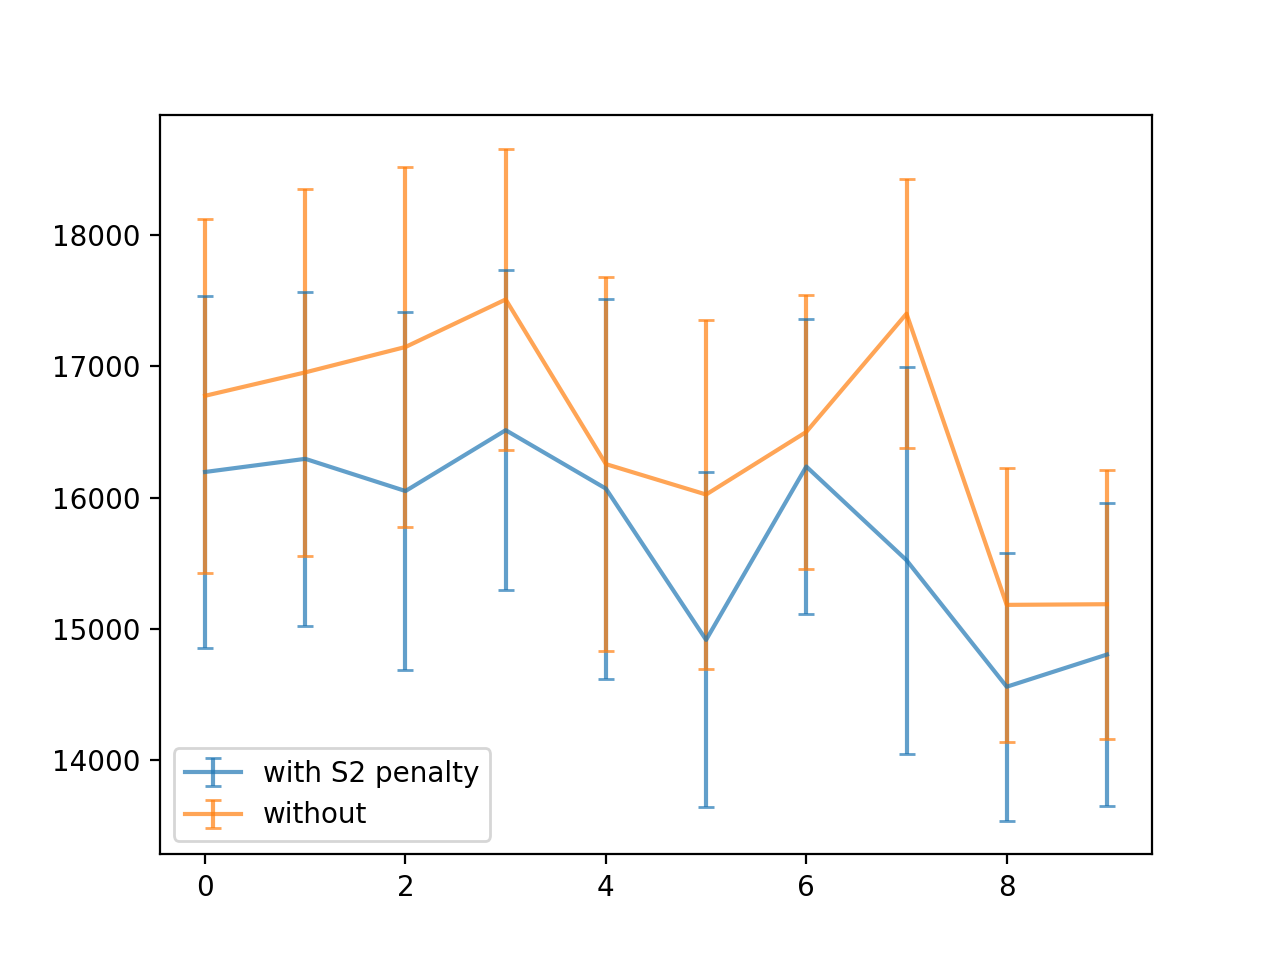

In [544]:
for dr in [dir_withPenalty, dir_without]:
    plt.errorbar(range(10),speedup[dr]['mean'],speedup[dr]['std'],capsize=3,alpha=0.7,label='with S2 penalty' if dr==dir_withPenalty else 'without')

plt.legend()

In [157]:
from scipy.stats import t

In [164]:
for r in range(10):
    T=(speedup[dir_without][r][0] - speedup[dir_withPenalty][r][0])/np.sqrt(speedup[dir_without][r][1]**2+speedup[dir_withPenalty][r][1]**2)
    print(t.cdf(T,23))

0.6186395950089008
0.6346593151778517
0.7119753440805603
0.7211805898882115
0.5362875882214627
0.7232657314475934
0.5674000567318324
0.8469369190841098
0.6633712453615499
0.5972157843969187


## Fidelity Estimation

In [577]:
cd /Users/congzlwag/Git/Tomography/MLEreviv/

/Users/congzlwag/Git/Tomography/MLEreviv


#### The random seeds prescribed for the training case

In [266]:
R=9
vR=9

In [296]:
fid2LnDist = lambda f: 0.5*np.log10((1-f**2)/2)

In [320]:
fid2Ratio = lambda f: 0.5*(1-f['real']**2)/((0.5*(1-f['succ']**2))**0.5)

<IPython.core.display.Javascript object>


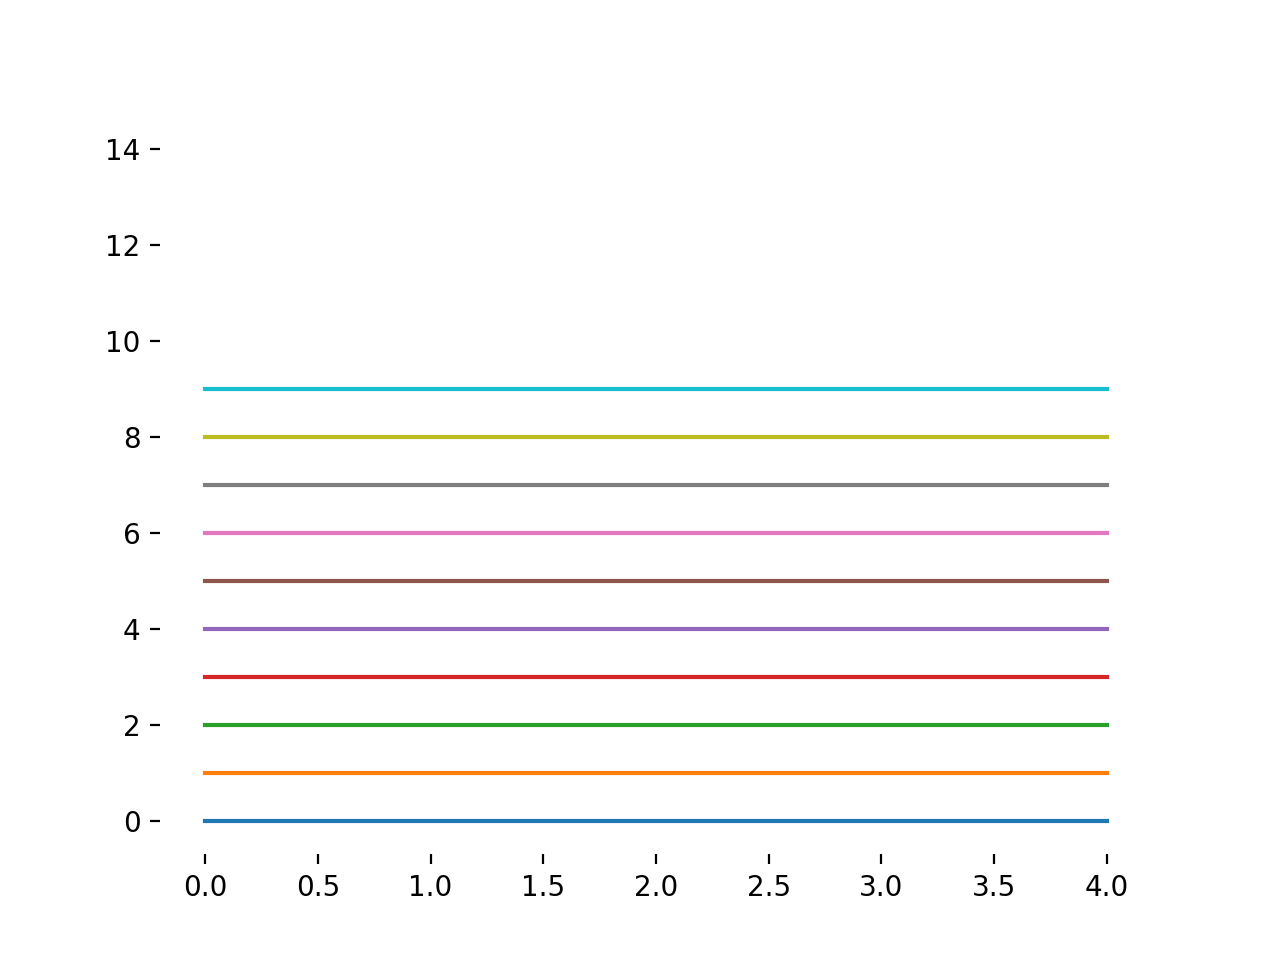

In [290]:
for r in range(15):
    plt.plot(range(5),[r]*5,label=str(r),color="C%d"%r)
plt.legend()

#### W30

In [578]:
fids = np.load('W/30/fids.npz')
virfids = np.load('trial13-FidEstL249/W/30/fids.npz')

In [251]:
virfids['V'].size

451

In [256]:
cut = np.s_[100:400]

In [252]:
Vs = fids['V']

In [296]:
fid2LnDist = lambda f: 0.5*np.log10((1-f**2)/2)

In [320]:
fid2Ratio = lambda f: 0.5*(1-f['real']**2)/((0.5*(1-f['succ']**2))**0.5)

<IPython.core.display.Javascript object>


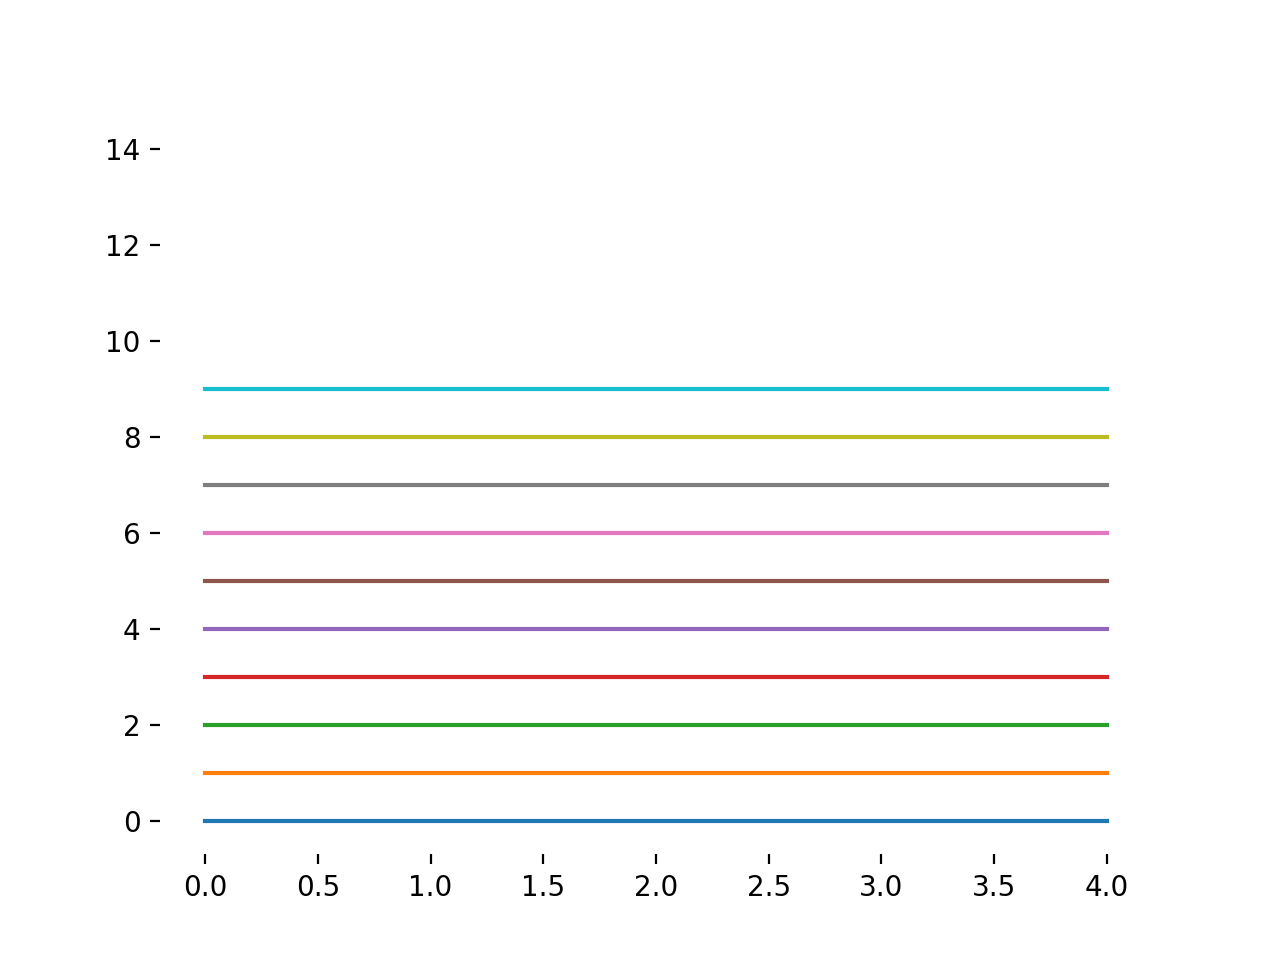

In [290]:
for r in range(15):
    plt.plot(range(5),[r]*5,label=str(r),color="C%d"%r)
plt.legend()

<IPython.core.display.Javascript object>


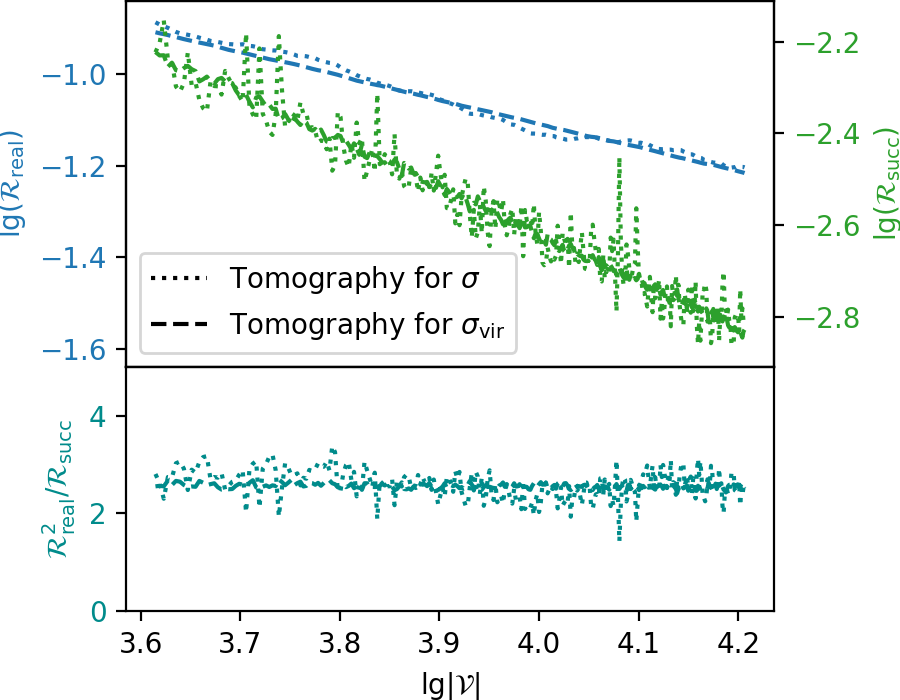

In [579]:
fig, axs = plt.subplots(2,1,sharex=True,gridspec_kw={'height_ratios':[3,2]},figsize=(4.5,3.5))
fig.subplots_adjust(hspace=0)

In [580]:
ax = axs[0]
clr = 'tab:blue'
ax.plot(np.log10(Vs[cut]), fid2LnDist(fids['real'][R,cut]),ls=':',c=clr)
ax.plot(np.log10(Vs[cut]), fid2LnDist(virfids['real'][:,cut]).mean(axis=0),c=clr,ls='--')

ax.set_ylabel(r'$\lg(\mathcal{R}_\mathrm{real})$',color=clr)
ax.set_ylim(-1.64,-0.84)
ax.yaxis.set_tick_params(labelcolor=clr)

In [581]:
ax = ax.twinx()
clr = 'tab:green'
ax.plot(np.log10(Vs[cut]), fid2LnDist(fids['succ'][R,cut]),ls=':',c=clr)
ax.plot(np.log10(Vs[cut]), fid2LnDist(virfids['succ'][:,cut]).mean(axis=0),c=clr,ls='--')
ax.set_ylabel(r'$\lg(\mathcal{R}_\mathrm{succ})$',color=clr)
ax.set_ylim(-2.91,-2.11)
ax.yaxis.set_tick_params(labelcolor=clr)

In [582]:
ax.plot([4,4], [-4.1,-4.1],color='k',ls=':',label=r"Tomography for $\sigma$")

ax.plot([4,4], [-4.1,-4.1],color='k',ls='--',label=r"Tomography for $\sigma_\mathrm{vir}$")

ax.legend(loc=3)

In [583]:
ax = axs[1]
clr = 'darkcyan'
ax.plot(np.log10(Vs[cut]),fid2Ratio(fids)[R][cut],ls=':',c=clr)
ax.plot(np.log10(Vs[cut]),fid2Ratio(virfids)[:,cut].mean(axis=0),ls='--',c=clr)
ax.set_ylabel(r'$\mathcal{R}_\mathrm{real}^2/\mathcal{R}_\mathrm{succ}$',color=clr)
ax.yaxis.set_tick_params(labelcolor=clr)

ax.set_ylim(0,5)

(0, 5)

In [584]:
axs[1].set_xlabel(r'$\lg|\mathcal{V}|$')

Text(0.5,18.4444,'$\\lg|\\mathcal{V}|$')

In [585]:
plt.subplots_adjust(left=0.14,right=0.86,bottom=0.127,top=0.999)

In [586]:
plt.savefig('ratio-W30.pdf')

#### dimer30

In [587]:
fids = np.load('dimer/30/fids.npz')
virfids = np.load('trial13-FidEstL249//dimer/30/fids.npz')

In [426]:
virfids['V'].size

451

In [427]:
cut = np.s_[100:400]

In [428]:
Vs = fids['V']

<IPython.core.display.Javascript object>


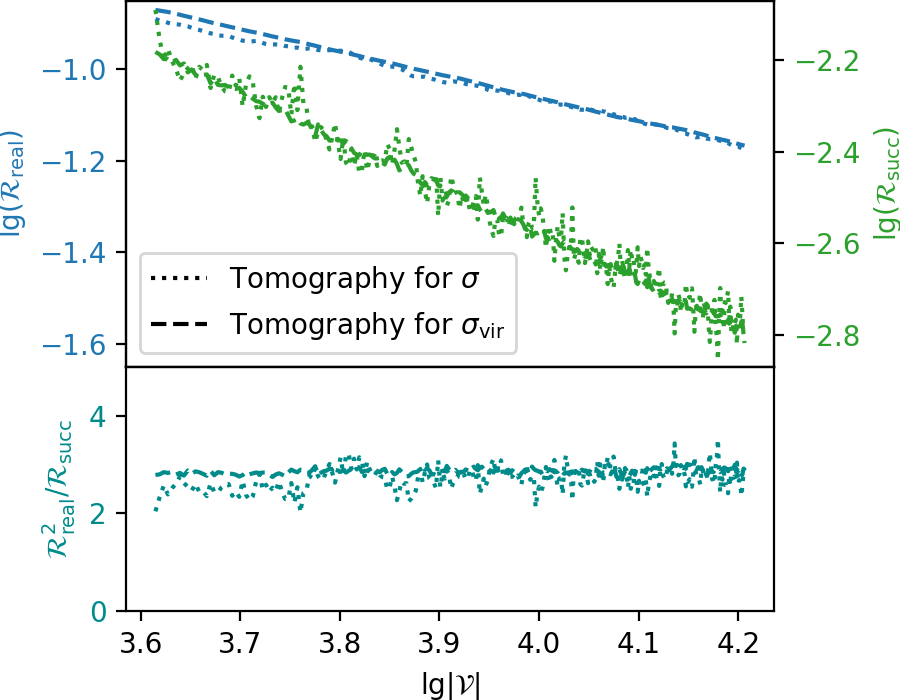

In [588]:
fig, axs = plt.subplots(2,1,sharex=True,gridspec_kw={'height_ratios':[3,2]},figsize=(4.5,3.5))
fig.subplots_adjust(hspace=0)

In [589]:
ax = axs[0]
clr = 'tab:blue'
ax.plot(np.log10(Vs[cut]), fid2LnDist(fids['real'][R,cut]),ls=':',c=clr)
ax.plot(np.log10(Vs[cut]), fid2LnDist(virfids['real'][:,cut]).mean(axis=0),c=clr,ls='--')

ax.set_ylabel(r'$\lg(\mathcal{R}_\mathrm{real})$',color=clr)

ax.yaxis.set_tick_params(labelcolor=clr)

In [590]:
ax = ax.twinx()
clr = 'tab:green'
ax.plot(np.log10(Vs[cut]), fid2LnDist(fids['succ'][R,cut]),ls=':',c=clr)
ax.plot(np.log10(Vs[cut]), fid2LnDist(virfids['succ'][:,cut]).mean(axis=0),c=clr,ls='--')
ax.set_ylabel(r'$\lg(\mathcal{R}_\mathrm{succ})$',color=clr)
ax.yaxis.set_tick_params(labelcolor=clr)

In [591]:
ax.set_ylim(-2.87,-2.07)

(-2.87, -2.07)

In [592]:
axs[0].set_ylim(-1.65,-0.85)

(-1.65, -0.85)

In [593]:
ax.plot([4,4], [-2.2,-2.2],color='k',ls=':',label=r"Tomography for $\sigma$")

ax.plot([4,4], [-2.2,-2.2],color='k',ls='--',label=r"Tomography for $\sigma_\mathrm{vir}$")

ax.legend(loc=3)

In [594]:
ax = axs[1]
clr = 'darkcyan'
ax.plot(np.log10(Vs[cut]),fid2Ratio(fids)[R][cut],ls=':',c=clr)
ax.plot(np.log10(Vs[cut]),fid2Ratio(virfids)[:,cut].mean(axis=0),ls='--',c=clr)
ax.set_ylabel(r'$\mathcal{R}_\mathrm{real}^2/\mathcal{R}_\mathrm{succ}$',color=clr)
ax.yaxis.set_tick_params(labelcolor=clr)

In [595]:
ax.set_ylim(0,5)

(0, 5)

In [596]:
axs[1].set_xlabel(r'$\lg|\mathcal{V}|$')

Text(0.5,18.4444,'$\\lg|\\mathcal{V}|$')

In [597]:
plt.subplots_adjust(left=0.14,right=0.86,bottom=0.127,top=0.999)

In [599]:
plt.savefig('ratio-dimer30.pdf')

#### cluster30

In [600]:
fids = np.load('cluster/30/fids.npz')
virfids = np.load('trial13-FidEstL249//cluster/30/fids.npz')

In [459]:
cut = np.s_[100:400]

In [601]:
Vs = fids['V']

<IPython.core.display.Javascript object>


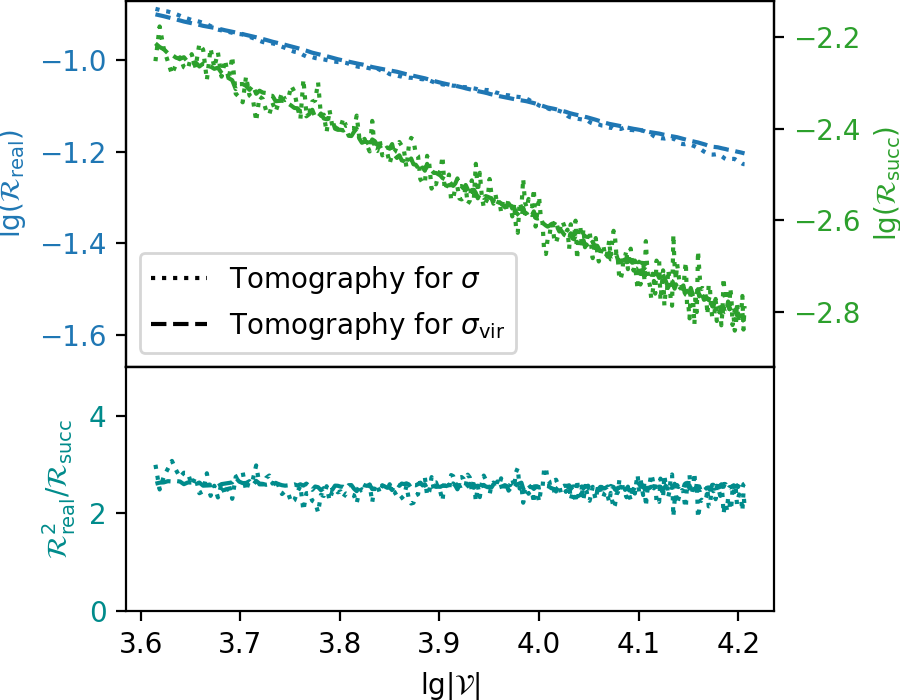

In [602]:
fig, axs = plt.subplots(2,1,sharex=True,gridspec_kw={'height_ratios':[3,2]},figsize=(4.5,3.5))
fig.subplots_adjust(hspace=0)

In [603]:
ax = axs[0]
clr = 'tab:blue'
ax.plot(np.log10(Vs[cut]), fid2LnDist(fids['real'][R,cut]),ls=':',c=clr)
ax.plot(np.log10(Vs[cut]), fid2LnDist(virfids['real'][:,cut]).mean(axis=0),c=clr,ls='--')

ax.set_ylabel(r'$\lg(\mathcal{R}_\mathrm{real})$',color=clr)

ax.yaxis.set_tick_params(labelcolor=clr)

In [604]:
ax = ax.twinx()
clr = 'tab:green'
ax.plot(np.log10(Vs[cut]), fid2LnDist(fids['succ'][R,cut]),ls=':',c=clr)
ax.plot(np.log10(Vs[cut]), fid2LnDist(virfids['succ'][:,cut]).mean(axis=0),c=clr,ls='--')
ax.set_ylabel(r'$\lg(\mathcal{R}_\mathrm{succ})$',color=clr)
ax.yaxis.set_tick_params(labelcolor=clr)

In [605]:
ax.set_ylim(-2.92,-2.12)

(-2.92, -2.12)

In [606]:
axs[0].set_ylim(-1.67,-0.87)

(-1.67, -0.87)

In [607]:
ax.plot([4,4], [-2.2,-2.2],color='k',ls=':',label=r"Tomography for $\sigma$")

ax.plot([4,4], [-2.2,-2.2],color='k',ls='--',label=r"Tomography for $\sigma_\mathrm{vir}$")

ax.legend(loc=3)

In [608]:
ax = axs[1]
clr = 'darkcyan'
ax.plot(np.log10(Vs[cut]),fid2Ratio(fids)[R][cut],ls=':',c=clr)
ax.plot(np.log10(Vs[cut]),fid2Ratio(virfids)[:,cut].mean(axis=0),ls='--',c=clr)
ax.set_ylabel(r'$\mathcal{R}_\mathrm{real}^2/\mathcal{R}_\mathrm{succ}$',color=clr)
ax.yaxis.set_tick_params(labelcolor=clr)

In [609]:
ax.set_ylim(0,5)

(0, 5)

In [610]:
axs[1].set_xlabel(r'$\lg|\mathcal{V}|$')

Text(0.5,18.4444,'$\\lg|\\mathcal{V}|$')

In [611]:
plt.subplots_adjust(left=0.14,right=0.86,bottom=0.127,top=0.999)

In [612]:
plt.savefig('ratio-cluster30.pdf')

#### random10 sd=9

In [613]:
fids = np.load('trial9-randomTarget/10/9/fids.npz')
virfids = np.load('trial13-FidEstL249//random/10/9/fids.npz')

In [475]:
fids['V'].size

431

In [476]:
cut = np.s_[100:400]

In [614]:
Vs = fids['V']

<IPython.core.display.Javascript object>


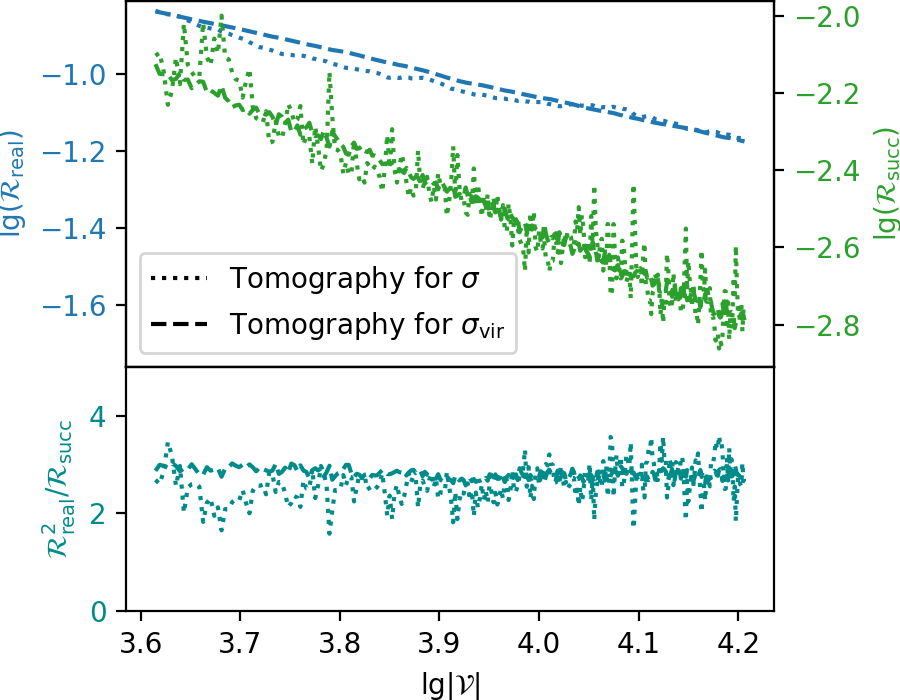

In [615]:
fig, axs = plt.subplots(2,1,sharex=True,gridspec_kw={'height_ratios':[3,2]},figsize=(4.5,3.5))
fig.subplots_adjust(hspace=0)

In [616]:
ax = axs[0]
clr = 'tab:blue'
ax.plot(np.log10(Vs[cut]), fid2LnDist(fids['real'][R,cut]),ls=':',c=clr)
ax.plot(np.log10(Vs[cut]), fid2LnDist(virfids['real'][:,cut]).mean(axis=0),c=clr,ls='--')

ax.set_ylabel(r'$\lg(\mathcal{R}_\mathrm{real})$',color=clr)

ax.yaxis.set_tick_params(labelcolor=clr)

In [617]:
ax = ax.twinx()
clr = 'tab:green'
ax.plot(np.log10(Vs[cut]), fid2LnDist(fids['succ'][R,cut]),ls=':',c=clr)
ax.plot(np.log10(Vs[cut]), fid2LnDist(virfids['succ'][:,cut]).mean(axis=0),c=clr,ls='--')
ax.set_ylabel(r'$\lg(\mathcal{R}_\mathrm{succ})$',color=clr)
ax.yaxis.set_tick_params(labelcolor=clr)

In [618]:
ax.set_ylim(-2.91,-1.96)

(-2.91, -1.96)

In [619]:
axs[0].set_ylim(-1.76,-0.81)

(-1.76, -0.81)

In [620]:
ax.plot([4,4], [-2.2,-2.2],color='k',ls=':',label=r"Tomography for $\sigma$")

ax.plot([4,4], [-2.2,-2.2],color='k',ls='--',label=r"Tomography for $\sigma_\mathrm{vir}$")

ax.legend(loc=3)

In [621]:
ax = axs[1]
clr = 'darkcyan'
ax.plot(np.log10(Vs[cut]),fid2Ratio(fids)[R][cut],ls=':',c=clr)
ax.plot(np.log10(Vs[cut]),fid2Ratio(virfids)[:,cut].mean(axis=0),ls='--',c=clr)
ax.set_ylabel(r'$\mathcal{R}_\mathrm{real}^2/\mathcal{R}_\mathrm{succ}$',color=clr)
ax.yaxis.set_tick_params(labelcolor=clr)

In [622]:
ax.set_ylim(0,5)

(0, 5)

In [623]:
axs[1].set_xlabel(r'$\lg|\mathcal{V}|$')

Text(0.5,18.4444,'$\\lg|\\mathcal{V}|$')

In [624]:
plt.subplots_adjust(left=0.14,right=0.86,bottom=0.127,top=0.999)

In [625]:
plt.savefig('ratio-random10.pdf')